# Autoregressive Generation with GPT 2


#### Load a tokenizer and a model

- Using the HuggingFace's transformers library.

In [95]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# To load a pretrained model and a tokenizer using HuggingFace, we only need two lines of code!
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

# We create a partial sentence and tokenize it.
text = "I am learning about Generative AI because"
inputs = tokenizer(text, return_tensors="pt")

# Show the tokens as numbers, i.e. "input_ids"
inputs["input_ids"]

tensor([[  40,  716, 4673,  546, 2980,  876, 9552,  780]])

In [96]:
# Show how the sentence is tokenized
import pandas as pd


def show_tokenization(inputs):
    return pd.DataFrame(
        [(id, tokenizer.decode(id)) for id in inputs["input_ids"][0]],
        columns=["id", "token"],
    )


show_tokenization(inputs)

,id,token
0,tensor(40),I
1,tensor(716),am
2,tensor(4673),learning
3,tensor(546),about
4,tensor(2980),Gener
5,tensor(876),ative
6,tensor(9552),AI
7,tensor(780),because


### Logits
Unnormalized scores (often referred to as logits) are the raw output values produced by a model before they are transformed into probabilities.

Logits are the output of the final layer of a neural network, typically before applying an activation function like softmax or sigmoid. They can be any real-valued number, positive or negative.

Logits represent the model's confidence in each class (for classification tasks) or the predicted value (for regression tasks) without being constrained to a specific range.

Logits can be interpreted as unbounded scores that indicate how strongly the model predicts each class. Higher logits correspond to higher confidence in a particular class.

##### Transformation to Probabilities

**Softmax Function:**  
In multi-class classification problems, logits are often passed through the softmax function to convert them into probabilities. The softmax function takes a vector of logits and transforms them into a probability distribution, where the sum of the probabilities equals 1. The formula for softmax is:

##$
P(y_i) = \frac{e^{\text{logit}_i}}{\sum_{j} e^{\text{logit}_j}}
$

where $( P(y_i) )$ is the probability of class
$( i )$, and $( \text{logit}_i $) is the logit for class $( i )$.

**Sigmoid Function:**  
In binary classification tasks, logits can be passed through the sigmoid function, which maps the output to a range between 0 and 1. The formula for the sigmoid function is:

##$
P(y) = \frac{1}{1 + e^{-\text{logit}}}
$


In [97]:
# Calculate the probabilities for the next token for all possible choices. We show the
# top 5 choices and the corresponding words or subwords for these tokens.

## GPT-2 has a vocab_size=50257

## the mode will output (batch_size, sequence_length, vocab_size)

import torch

with torch.no_grad():
    logits = model(**inputs).logits[:, -1, :]
    probabilities = torch.nn.functional.softmax(logits[0], dim=-1)

print("Logits : ", logits, logits.shape)

Logits :  tensor([[ -97.1139,  -97.4626, -103.1839,  ..., -102.7820, -105.1304,
          -98.6559]]) torch.Size([1, 50257])


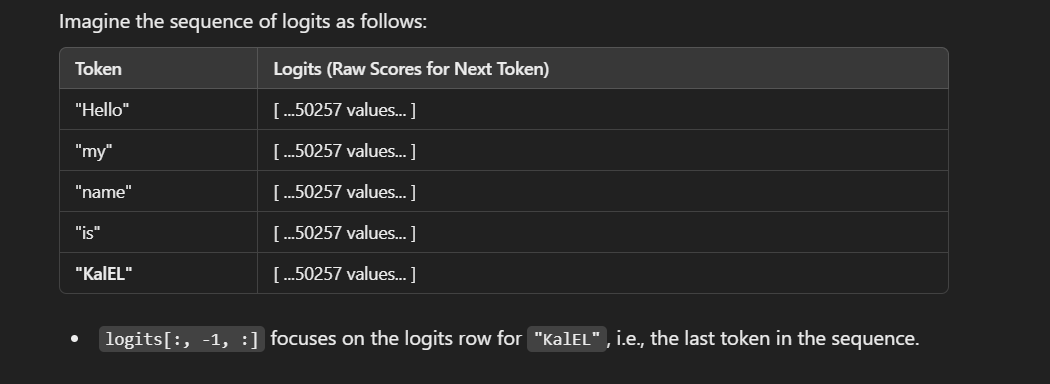

In [98]:
def show_next_token_choices(probabilities, top_n=5):
    return pd.DataFrame(
        [
            (id, tokenizer.decode(id), p.item())
            for id, p in enumerate(probabilities)
            if p.item()
        ],
        columns=["id", "token", "p"],
    ).sort_values("p", ascending=False)[:top_n]


show_next_token_choices(probabilities)

,id,token,p
314,314,I,0.419635
340,340,it,0.133006
286,286,of,0.127496
262,262,the,0.042601
616,616,my,0.020440


In [99]:
# Obtain the token id for the most probable next token
next_token_id = torch.argmax(probabilities).item()

print(f"Next token id: {next_token_id}")
print(f"Next token: {tokenizer.decode(next_token_id)}")

Next token id: 314
Next token:  I


In [100]:
# We append the most likely token to the text.
text = text + tokenizer.decode(next_token_id)
text

'I am learning about Generative AI because I'

In [101]:
# Press ctrl + enter to run this cell again and again to see how the text is generated.

from IPython.display import Markdown, display

# Show the text
print(text)

# Convert to tokens
inputs = tokenizer(text, return_tensors="pt")

# Calculate the probabilities for the next token and show the top 5 choices
with torch.no_grad():
    logits = model(**inputs).logits[:, -1, :]
    probabilities = torch.nn.functional.softmax(logits[0], dim=-1)

display(Markdown("**Next token probabilities:**"))
display(show_next_token_choices(probabilities))

# Choose the most likely token id and add it to the text
next_token_id = torch.argmax(probabilities).item()
text = text + tokenizer.decode(next_token_id)

I am learning about Generative AI because I


**Next token probabilities:**

,id,token,p
716,716,am,0.166642
423,423,have,0.139067
765,765,want,0.055837
1101,1101,'m,0.046267
373,373,was,0.040653


In [102]:
from IPython.display import Markdown, display

# Start with some text and tokenize it
text = "I am learning about Generative AI because I believe"
inputs = tokenizer(text, return_tensors="pt")

# Use the `generate` method to generate lots of text
output = model.generate(**inputs, max_length=100, pad_token_id=tokenizer.eos_token_id)

# Show the generated text
display(Markdown(tokenizer.decode(output[0])))

I am learning about Generative AI because I believe that it is the future of AI. I believe that it is the future of the human race. I believe that it is the future of the human race. I believe that it is the future of the human race. I believe that it is the future of the human race. I believe that it is the future of the human race. I believe that it is the future of the human race. I believe that it is the future of the human